In [1]:
%matplotlib inline

from core import *

samples = analysis_set["main"]

def get_kmer_profiles(rna, subsample = 200000, kmer_size = 5):
    infile = samfiles[rna]
    print("Processing sample", infile)
    seqs = read_samfile(rna, infile, subsample)
    
    kmer_dict = init_kmer_dict(kmer_size)
    motif_acc = {}
    for kmer in ['GA', 'AG', 'GU', 'UG', 'GC', 'CG', 'AC', 'CA', 'AU','UA', 'UC', 'CU',]:
        motif_acc[kmer] = {} #[0, 0, 0, 0] #{}
    confusion = np.zeros((5, 4), dtype = int)
    base2index = {"A":0, "C":1, "G":2, "U":3, "_":4}
    
    for seq_num in tqdm(range(np.minimum(len(seqs), subsample))):
        name, flag, start, cigar, sample_seq, mapq, chromo, qs_base = seqs[seq_num]
        cigar_splitted = re.split('([^0-9])',cigar.strip())
        cigar_expanded, n_clips = '', 0
        for index in range(0, len(cigar_splitted)-1, 2): # items[-1] is actually ""
            count, symbol = int(cigar_splitted[index]), cigar_splitted[index+1]
            if symbol == "S":
                n_clips += count
            else:
                cigar_expanded = cigar_expanded + ''.join([symbol * count])
        ref_start = int(start) - 1 # samfiles are 1-based
        ref_end = ref_start + len(sample_seq) - cigar_expanded.count("I") + cigar_expanded.count("D") + cigar_expanded.count("N") - n_clips
        
        sample_seq = sample_seq[int(cigar_splitted[0]):] if cigar_splitted[1] == "S" else sample_seq
        sample_seq = sample_seq[:-int(cigar_splitted[-3])] if cigar_splitted[-2] == "S" else sample_seq
        ref_seq = refs[rna].fetch(reference = chromo, start = ref_start, end = ref_end)
        
        qs_base = qs_base[int(cigar_splitted[0]):] if cigar_splitted[1] == "S" else qs_base
        qs_base = qs_base[:-int(cigar_splitted[-3])] if cigar_splitted[-2] == "S" else qs_base
        
        if "N" in ref_seq or ref_seq.upper() != ref_seq: # Is this necessary?
            continue
            
        strand = '-' if int(flag) & 0x10 else '+'
        if strand == '-':
            sample_seq = rev_compl(sample_seq)
            ref_seq = rev_compl(ref_seq)
            cigar_expanded = cigar_expanded[::-1]
            qs_base = qs_base[::-1]

        # Expand sample sequence by adding deletions _ and removing insertions
        expanded_sample, p_sample, p_ref, insert_pos = '', 0, 0, {}
        p_cigar = 0 if cigar_splitted[1] != "S" else 2
        
        for i in range(len(cigar_expanded)):
            if cigar_expanded[i] == "=" or cigar_expanded[i] == "X":
                expanded_sample += sample_seq[p_sample]
                p_sample += 1
                p_ref += 1
                    
            elif cigar_expanded[i] == "D":
                expanded_sample += "_"
                p_ref += 1
            elif cigar_expanded[i] == "N":
                expanded_sample += "N"
                p_ref += 1
            elif cigar_expanded[i] == "I":
                # p_sample += 1                       
                if cigar_expanded[i-1] != "I":
                    insert_pos[p_ref] = sample_seq[p_sample] if sample_seq[p_sample] != "T" else "U" 
                    p_sample += 1
                    step = 1
                    while cigar_expanded[i+step] == "I":
                        insert_pos[p_ref] += sample_seq[p_sample] if sample_seq[p_sample] != "T" else "U"
                        step += 1
                        p_sample += 1                        
        
        if len(expanded_sample) != len(ref_seq):
            print("expansion didn't work!!")
        
        ref_seq = ref_seq.replace("T", "U")
        expanded_sample = expanded_sample.replace("T", "U")
            
        # print(cigar)print(ref_seq)print(sample_seq)print(insert_pos)
        
        for i in range(len(ref_seq)):
            if expanded_sample[i] != "N":
                if ref_seq[i] in base2index:
                    ref_index, sam_index = base2index[ref_seq[i]], base2index[expanded_sample[i]]
                    confusion[sam_index, ref_index] += 1
        
        step = 2
        for i in range(len(ref_seq)-step+1):
            kmer = ref_seq[i:i+step]
            sample_kmer = expanded_sample[i:i+step]
            
            ins_flag, inserts = False, []
            for j in range(i+1, i+step):
                if j in insert_pos:
                    ins_flag = True
                    inserts.append((j-i-1, insert_pos[j]))
            if ins_flag == True:
                for loc, insert in inserts:
                    inserted_kmer = sample_kmer[:loc+1] + insert + sample_kmer[loc+1:]
                sample_kmer = inserted_kmer
                # print(i, kmer, sample_kmer, inserted_kmer, inserts)

            if "N" not in sample_kmer and kmer in motif_acc:
                if sample_kmer not in motif_acc[kmer]:
                    motif_acc[kmer][sample_kmer] = 0
                motif_acc[kmer][sample_kmer] += 1
                
        window = (kmer_size - 1) // 2
        for i in range(len(ref_seq)-kmer_size+1):
            kmer = ref_seq[i:i+kmer_size]
            sample_kmer = expanded_sample[i:i+kmer_size]
            if kmer in kmer_dict and "N" not in sample_kmer:
                if kmer[0:window] == sample_kmer[0:window] and kmer[kmer_size-window:kmer_size] == sample_kmer[kmer_size-window:kmer_size]:
                    if sample_kmer not in kmer_dict[kmer]:
                        kmer_dict[kmer][sample_kmer] = 0
                    kmer_dict[kmer][sample_kmer] += 1
    
    return kmer_dict, motif_acc, confusion

kmer_profiles, kmer_acc_sorted, motif_acc, confusion = {}, {}, {}, {}
for sample in samples:
    if sample not in motif_acc:
        kmer_profiles[sample], motif_acc[sample], confusion[sample] = get_kmer_profiles(sample, kmer_size=3)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ins_dict = {}
ins_rate = {}
sample = "Human"
for motif in motif_acc[sample]:
    total = np.sum(list(motif_acc[sample][motif].values()))
    ins_total = 0
    for basecall in motif_acc[sample][motif]:
        if len(basecall) > 2:
            ins_total += motif_acc[sample][motif][basecall]
    print(motif, ins_total / total)
    ins_rate[motif] = ins_total / total
    ins_dict[motif] = {}
    ins_dict[motif]["others"] = 0 
    for basecall in motif_acc[sample][motif]:
        if len(basecall) > 2:
            if motif_acc[sample][motif][basecall] > 0.05 * ins_total:
                ins_dict[motif][basecall] = motif_acc[sample][motif][basecall] 
            else:
                ins_dict[motif]["others"] += motif_acc[sample][motif][basecall]

GA 0.019908348400204078
AG 0.006065806732138409
GU 0.02394499825575864
UG 0.016246137594084248
GC 0.020973916126103154
CG 0.01836553492152817
AC 0.013461392626465823
CA 0.02234043200178396
AU 0.023148847698226387
UA 0.023412630280945222
UC 0.021122726948151097
CU 0.031227346688928716


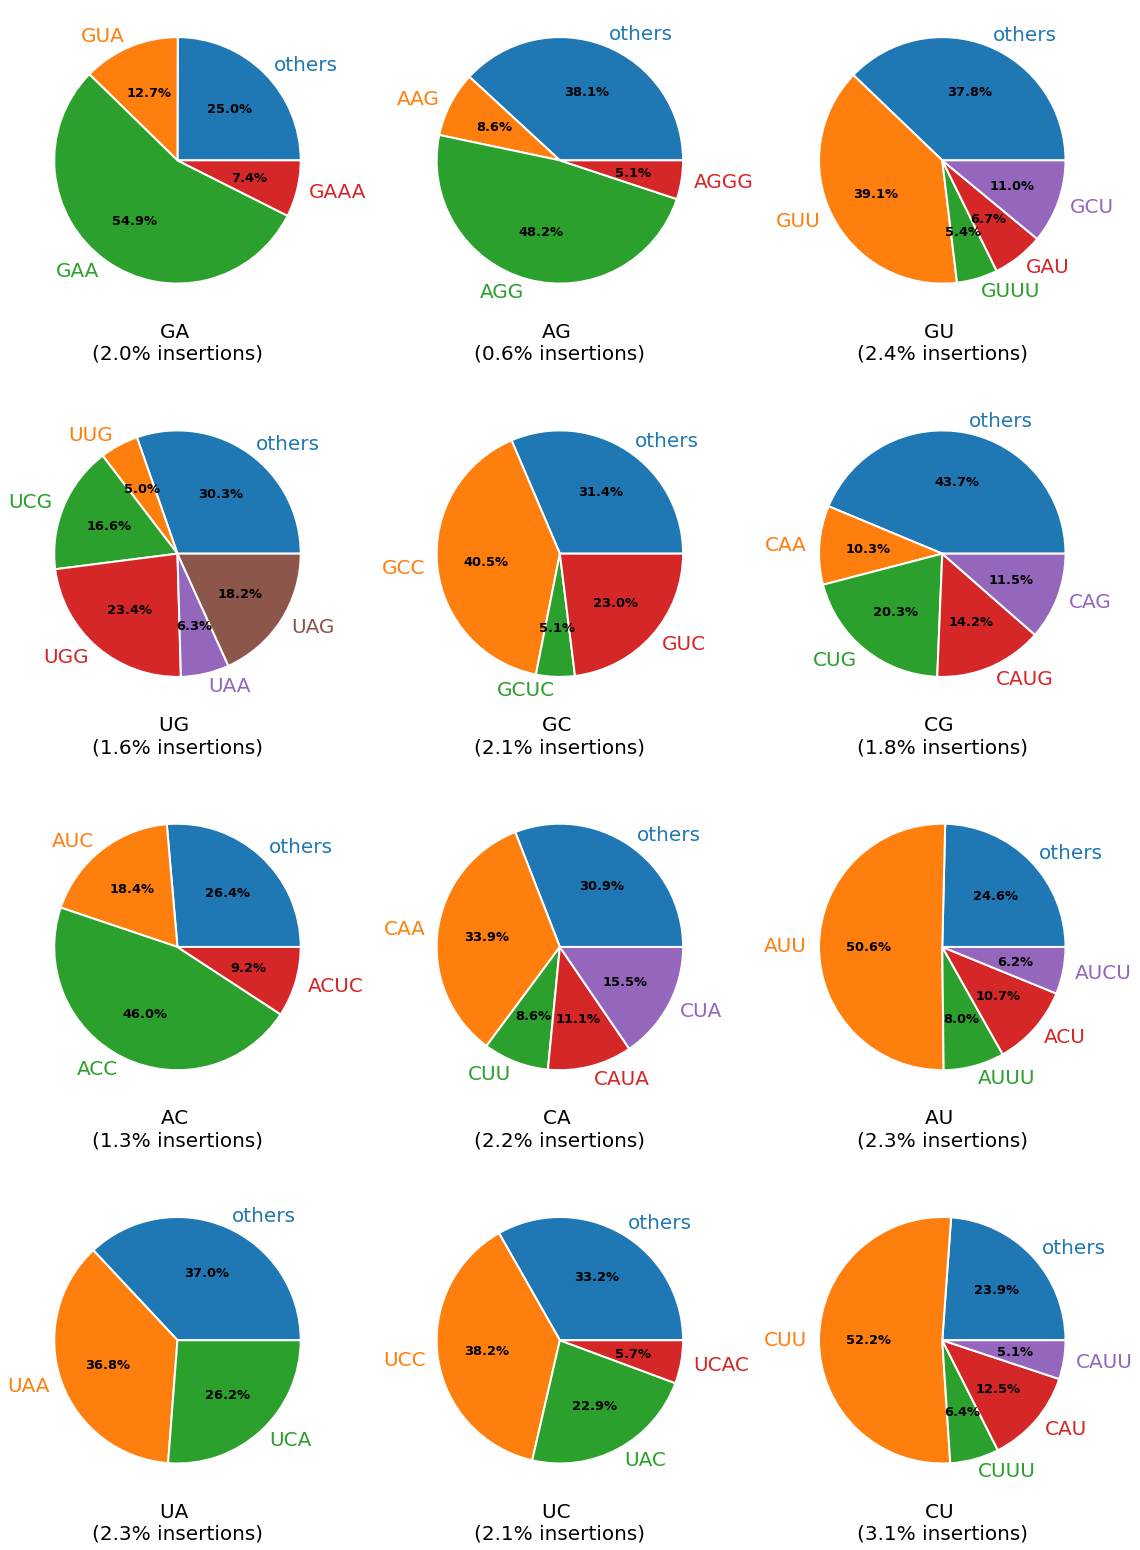

In [3]:
motifs = ['GA', 'AG', 'GU', 'UG', 'GC', 'CG', 'AC', 'CA', 'AU','UA', 'UC', 'CU']
fig, axes = plt.subplots(4, 3, figsize=(16, 22))

row, col = 0, 0
for i in range(len(motifs)):
    motif = motifs[i]    
    sizes = np.array(list(ins_dict[motif].items()))[:, 1]
    labels = np.array(list(ins_dict[motif].items()))[:, 0]
    patches, texts, pcts = axes[row, col].pie(sizes, labels = labels, 
        wedgeprops=dict(linewidth=2, edgecolor='white'), textprops={"size": "20"},
        autopct='%1.1f%%', radius=1)
        # colors=sns.color_palette("pastel")
    
    for x, patch in enumerate(patches):
        texts[x].set_color(patch.get_facecolor())
    plt.setp(pcts, fontsize = 13, fontweight = 'bold')
    axes[row, col].set_xlabel("%s \n(%.1f%% insertions)" % (motif, ins_rate[motif]*100),fontsize = 20)
    
    col += 1
    if col == 3:
        row += 1
        col = 0
    
plt.tight_layout()
# plt.savefig("images/fig2/insert_all", bbox_inches="tight")
plt.show()

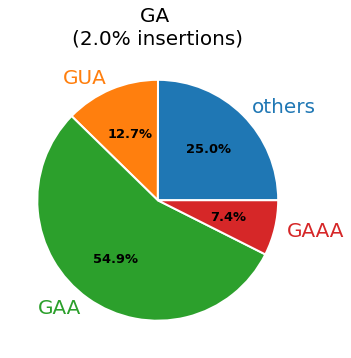

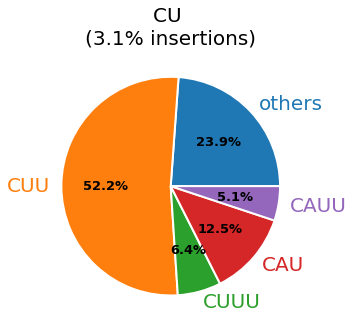

In [4]:
for motif in ['GA', "CU"]: #'AG', 'GU', 'UG', 'GC', 'CG', 'AC', 'CA', 'AU','UA', 'UC', 'CU']:
    fig, ax = plt.subplots(figsize = (5, 7))
    sizes = np.array(list(ins_dict[motif].items()))[:, 1]
    labels = np.array(list(ins_dict[motif].items()))[:, 0]
    patches, texts, pcts = ax.pie(sizes, labels = labels, 
        wedgeprops=dict(linewidth=2, edgecolor='white'), textprops={"size": "20"},
        autopct='%1.1f%%', radius=1)
        # colors=sns.color_palette("pastel")
    
    for i, patch in enumerate(patches):
        texts[i].set_color(patch.get_facecolor())
    plt.setp(pcts, fontsize = 13, fontweight = 'bold')
    ax.set_title("%s \n(%.1f%% insertions)" % (motif, ins_rate[motif]*100), fontsize = 20)
    plt.tight_layout()
    # plt.savefig("images/fig2/insert_" + motif, bbox_inches="tight")
    plt.show()

In [5]:
x, y, hue = [], [], []
for sample in samples:
    for motif in motif_acc[sample]:
        total = np.sum(list(motif_acc[sample][motif].values()))
        error_total = total - motif_acc[sample][motif][motif]
        del_count, ins_count = 0, 0
        for basecall in motif_acc[sample][motif]:
            if "_" in basecall:
                del_count += motif_acc[sample][motif][basecall]
                
            if len(basecall) > 2:
                ins_count += motif_acc[sample][motif][basecall]
        
        x.append(motif)
        y.append(del_count / total)
        hue.append("deletion")
        
        x.append(motif)
        y.append(ins_count / total)
        hue.append("insertion")
        
        x.append(motif)
        y.append((error_total - del_count - ins_count) / total)
        hue.append("mismatch")
print(len(x), len(y), len(hue))

432 432 432


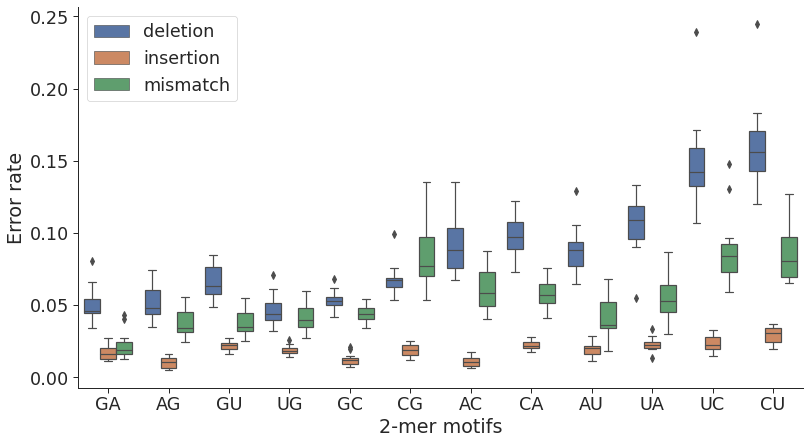

In [6]:
sns.set(rc = {'figure.figsize': (13, 7)})   
sns.set_context("paper", font_scale = 2)
sns.set_style("ticks")
sns.boxplot(x=x, y=y, hue=hue)
sns.despine()
plt.ylabel("Error rate"), plt.xlabel("2-mer motifs")
# plt.savefig("images/fig2/2mer_errors", bbox_inches="tight")
plt.show()

Human
Human_IVT
Mouse
Zebrafish
C. elegans
Arabidopsis
H. volcanii
E. coli
shortRNAs_IVT
Yeast
SARS2
SARS2_IVT


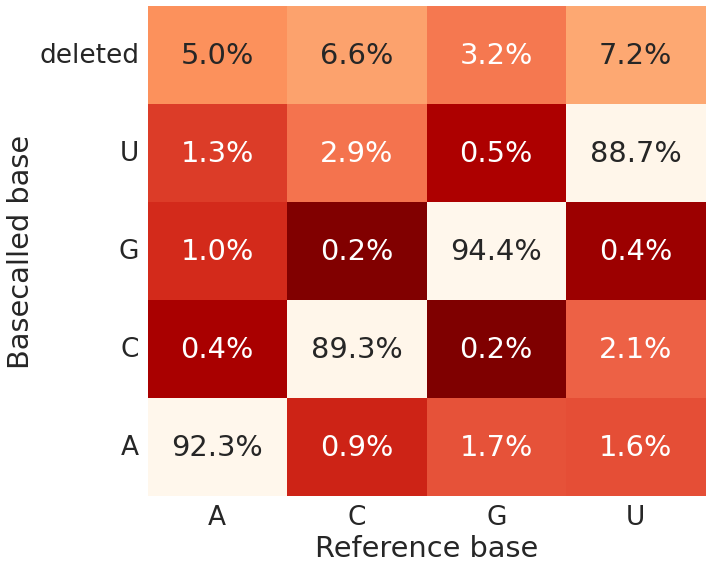

In [7]:
confusion_matrices = []
for sample in samples:
    print(sample)
    confusion_norm = np.flip(confusion[sample] / np.sum(confusion[sample], axis = 0)[None, :], axis = 0)
    confusion_matrices.append(confusion_norm)
confusion_norm = np.mean(np.array(confusion_matrices), axis = 0)
sns.set(rc = {'figure.figsize': (10, 9)})   
sns.set_context("paper", font_scale = 3)
sns.heatmap(-np.log(confusion_norm), annot=confusion_norm, fmt='.1%', 
            xticklabels=["A", "C", "G", "U"], cmap="OrRd", cbar = False,
            yticklabels=np.flip(["A", "C", "G", "U", "deleted"]))
plt.xlabel("Reference base"), plt.ylabel("Basecalled base")
plt.yticks(rotation = 0)
# plt.savefig("images/fig2/confusion_mean", bbox_inches = "tight")
plt.show()

Human


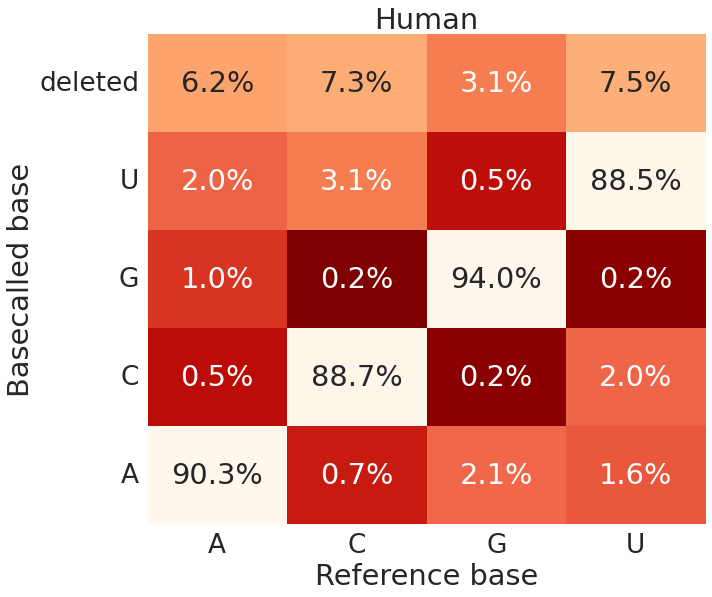

Human_IVT


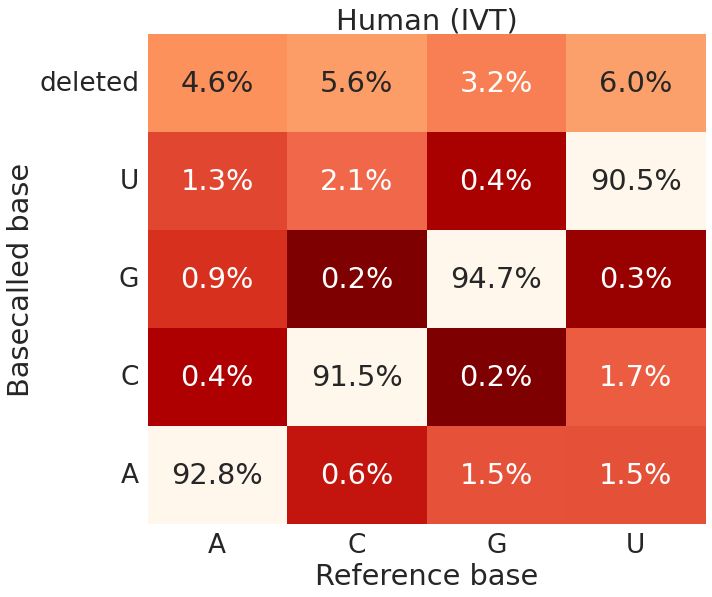

Mouse


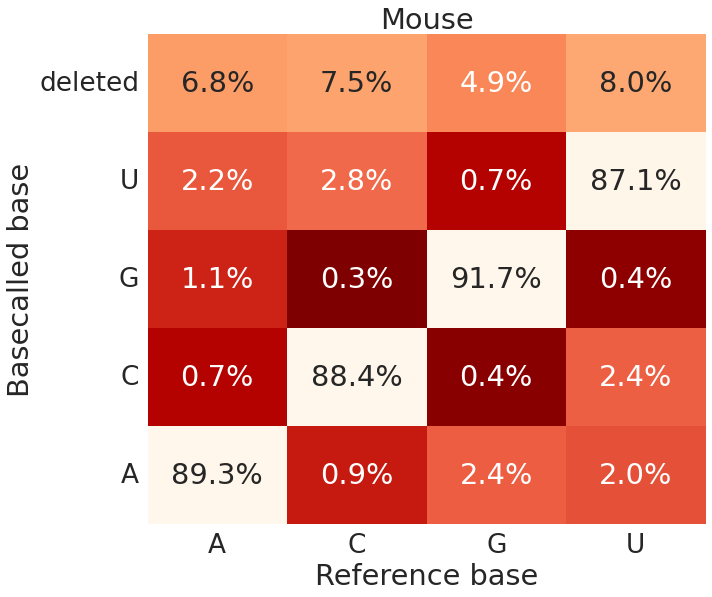

Zebrafish


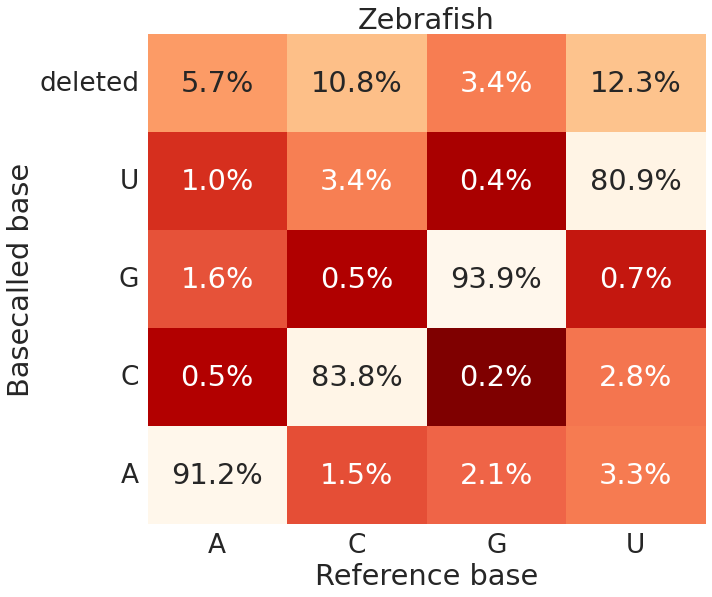

C. elegans


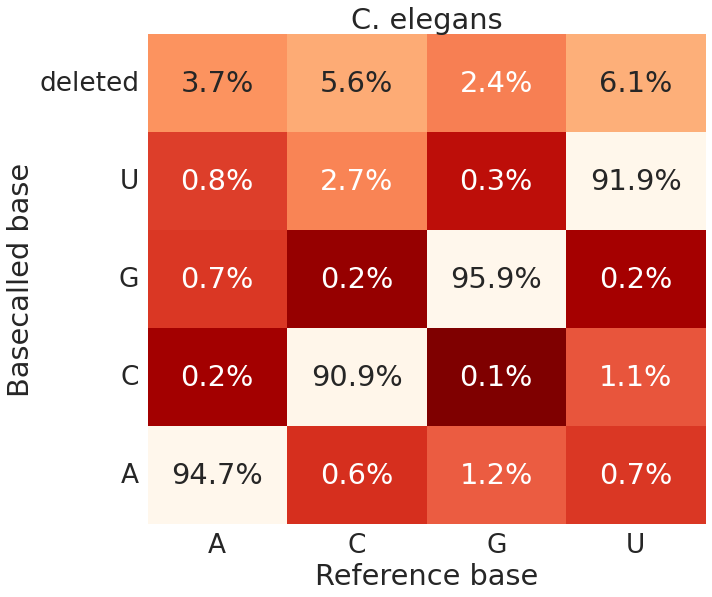

Arabidopsis


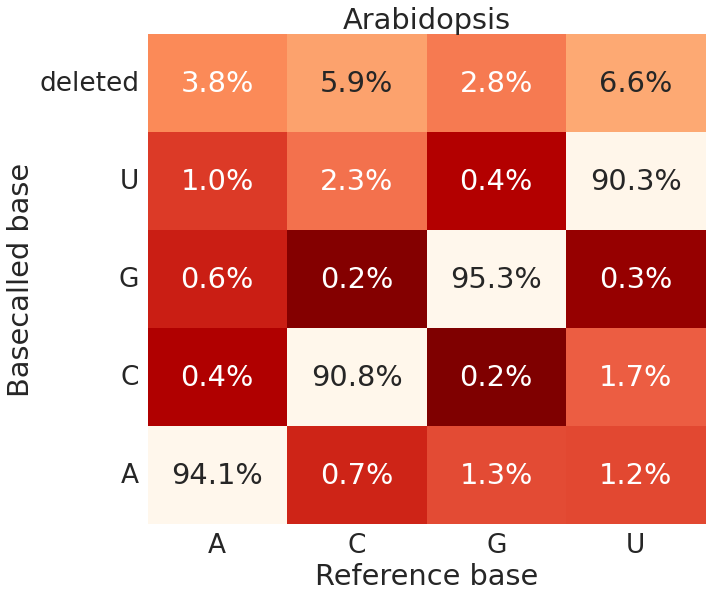

H. volcanii


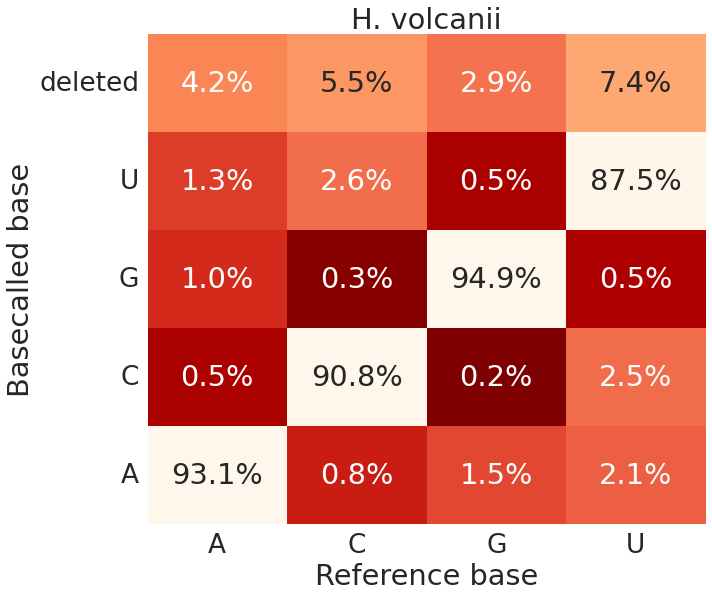

E. coli


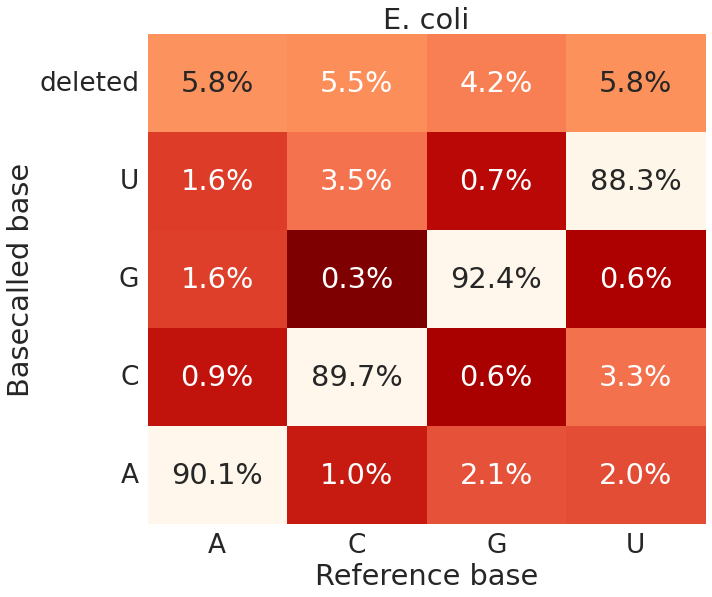

shortRNAs_IVT


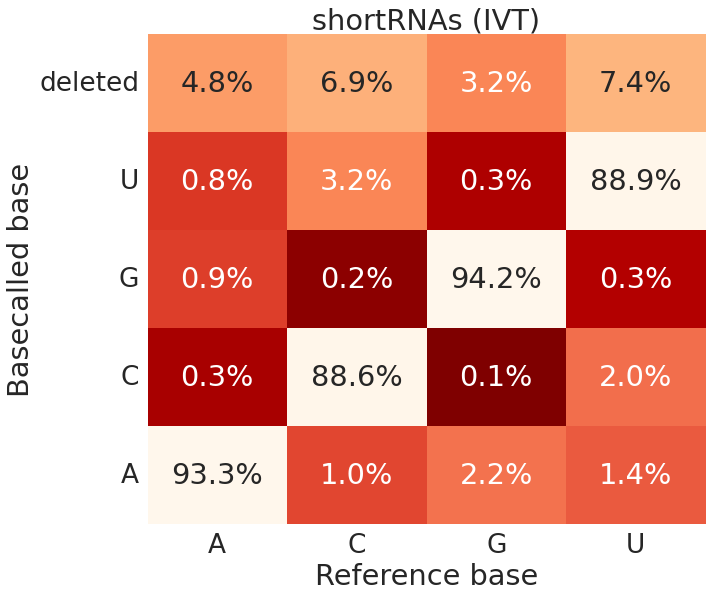

Yeast


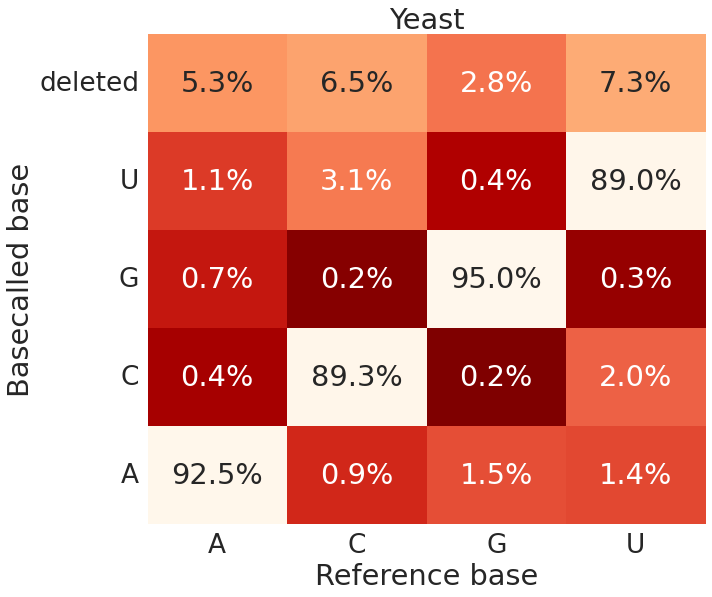

SARS2


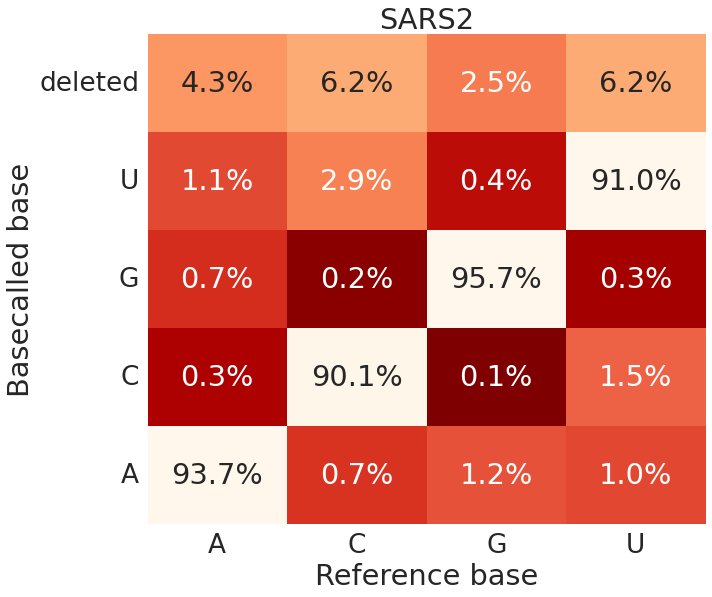

SARS2_IVT


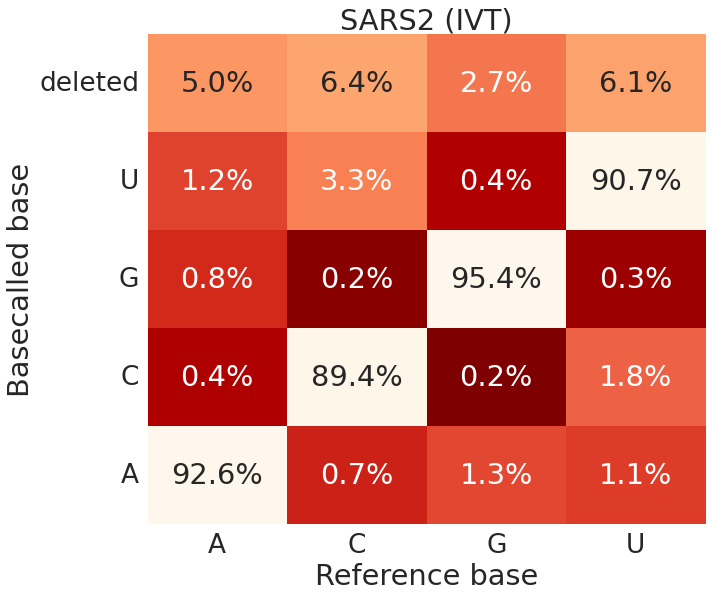

In [8]:
sns.set(rc = {'figure.figsize': (10, 9)})   
sns.set_context("paper", font_scale = 3)
for sample in samples:
    print(sample)
    confusion_norm = np.flip(confusion[sample] / np.sum(confusion[sample], axis = 0)[None, :], axis = 0)
    sns.heatmap(-np.log(confusion_norm), annot=confusion_norm, fmt='.1%', 
            xticklabels=["A", "C", "G", "U"], cmap="OrRd", cbar = False,
            yticklabels=np.flip(["A", "C", "G", "U", "deleted"]))
    plt.xlabel("Reference base"), plt.ylabel("Basecalled base")
    plt.yticks(rotation = 0)
    plt.title(sample.replace("_IVT", " (IVT)"))
    # plt.savefig("images/confusion/confusion_" + sample.replace(". ", ""), bbox_inches = "tight")
    plt.show()

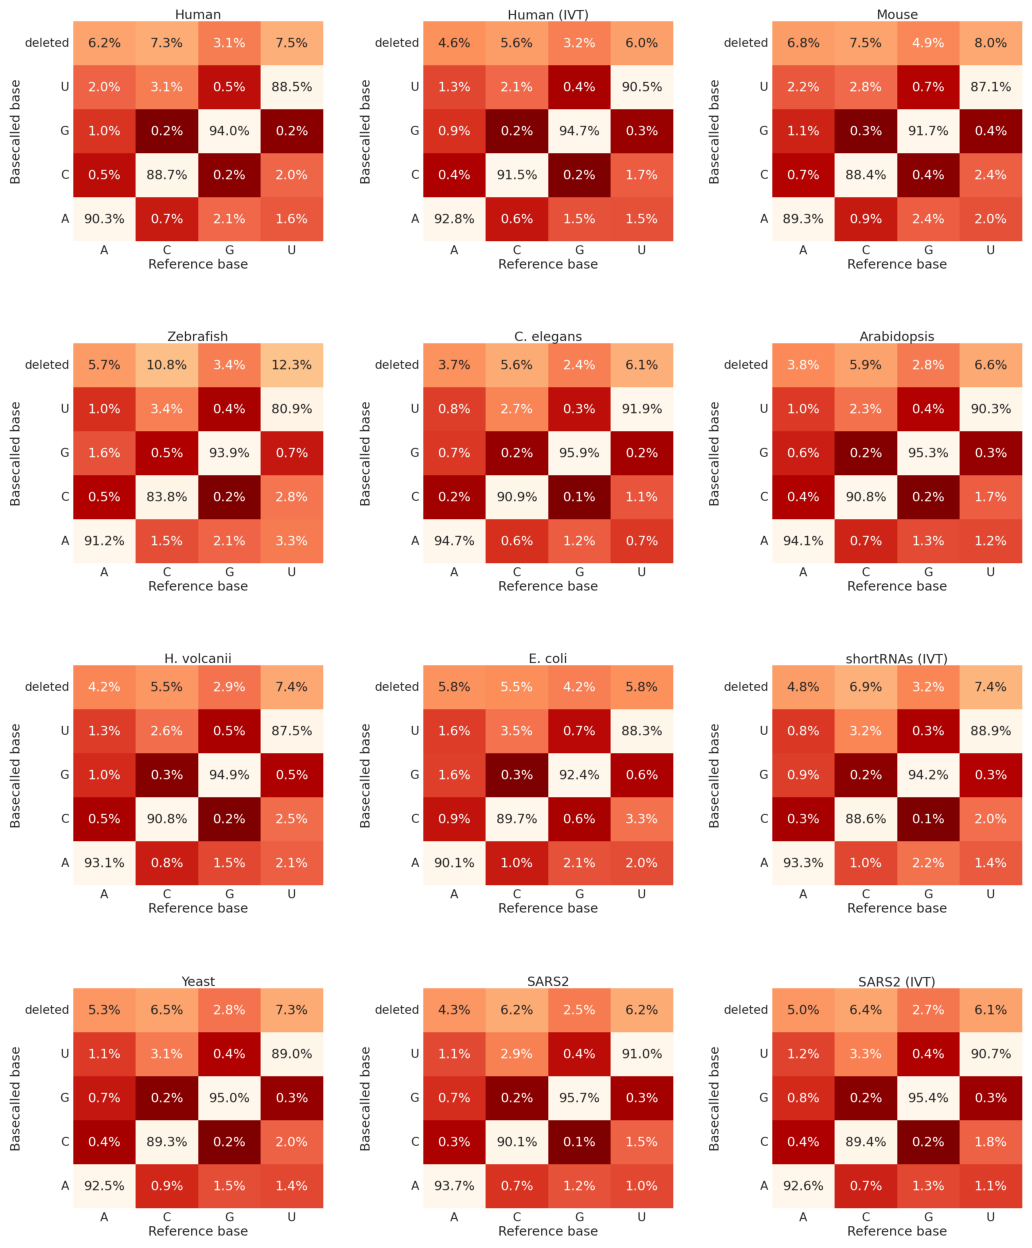

In [9]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes[-1, -1].axis("off")
axes[-1, -2].axis("off")
row, col = 0, 0
for sample in samples:
    img = mpimg.imread("images/confusion/confusion_" + str(sample).replace(". ", "") + ".png")
    axes[row, col].imshow(img)
    axes[row, col].axis("off")
    fig.tight_layout()
    
    col += 1
    if col == 3:
        row += 1
        col = 0
fig.tight_layout()
# plt.savefig("images/fig2/confusion_all", bbox_inches = "tight")
plt.show()